Hello, this is our Data Science Studio Final Project. Today, we will be performing an analysis and creating mutliple classification models using the DCWP Consumer Complaints Dataset. Consumer complaints are an important signal for identifying patterns of dissatisfaction, fraud, or misconduct among businesses. By analyzing consumer complaints, agencies and companies can improve cutomer service, ensure compliance with regulations, and protect consumers from unfair practices.

### The aim of this analysis

Today, we will assume the role of data analysts working for a consumer protection agency. We need to analyze the DCWP Consumer Complaints dataset and develop classification models that could accurately predict the status of a consumer complaint based on various factors such as the type of business, type of complaint, and subission methods. We will also evaluate the different models to see which one performs better. Some of the questions we aim to answer are:
- Which features are most import in determining the final status of a consumer complaint?
- Can we identify any patterns or trends in the types of complaints received across different business categories?
- Can we build a predictive model that can accurately classify the complaint status based on the available information?

### Introducing the Dataset

The dataset we will be using for this project is the DCWP Consumer Complaints Datset, which we retrieved from the NYC Open Data Portal using an API. The Department of Consumer and WOrker Protection (DCWP) records complaints filed by consumers against businesses operating in New York City. This dataset provides valuable insights into consumer issues and business compliance across various inductries.

The features we will be using in this project are:

Let's start by exploring the dataset!

In [39]:
# Importing necessary libraries

from sodapy import Socrata
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier


In [40]:
# Creating a client object to make API requests

client = Socrata("data.cityofnewyork.us", None)

In [41]:
# The ID of the dataset

dataset_id = "nre2-6m2s"

In [42]:
# Getting the data

results = client.get(dataset_id, limit = 5000)

In [43]:
# Putting it into a dataframe

df = pd.DataFrame.from_records(results)

In [44]:
df.head()

,record_id,intake_date,intake_channel,_311_sr_number,business_category,complaint_code,business_unique_id,business_name,result_date,result,...,census_tract_2010_,latitude,longitude,referred_to,street2,apt_suite,unit_type,refund_amount,street3,contract_cancelled_amount
0,057319-2025-CMPL,2025-02-24T00:00:00.000,311,311-22036401,Misc Non-Food Retail,Non-Delivery of Goods - N01,BA-1722067-2025,BURGER KING,2025-02-24T00:00:00.000,Complaint Review Complete,...,109,40.74997771919704,-73.98792375849172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,057324-2025-CMPL,2025-02-24T00:00:00.000,311,311-22036709,Supermarket,Overcharge,BA-1722116-2025,A & Y Embassy Food Corp.,2025-02-24T00:00:00.000,Referred,...,539,40.707436555829005,-73.9154949964182,NYS Office of the Attorney General,NaN,NaN,NaN,NaN,NaN,NaN
2,057329-2025-CMPL,2025-02-24T00:00:00.000,311,311-22038149,Restaurant,Price Gouging,BA-1722078-2025,pateizia restaurant,2025-02-24T00:00:00.000,Referred,...,66,40.73991700211976,-73.97939843013278,Other,NaN,NaN,NaN,NaN,NaN,NaN
3,057308-2025-CMPL,2025-02-23T00:00:00.000,311,311-22035243,Other,Overcharge,NaN,NaN,2025-02-24T00:00:00.000,Referred,...,35,40.68443681704665,-73.97772453928852,Other,NaN,NaN,NaN,NaN,NaN,NaN
4,057283-2025-CMPL,2025-02-23T00:00:00.000,311,311-22030279,Temporary Street Fair Vendor Permit,Unlicensed,BA-1722035-2025,Collins flea market,2025-02-24T00:00:00.000,Referred,...,1078,40.662513864493334,-73.87200681167306,NYC Department of Sanitation,WORTMAN AVENUE,NaN,NaN,NaN,NaN,NaN


In [45]:
# Checking the initial shape of the dataset

df.shape

(5000, 33)

In [46]:
# The columns

df.columns.tolist()

['record_id',
 'intake_date',
 'intake_channel',
 '_311_sr_number',
 'business_category',
 'complaint_code',
 'business_unique_id',
 'business_name',
 'result_date',
 'result',
 'address_type',
 'building_nbr',
 'street1',
 'city',
 'state',
 'postcode',
 'borough',
 'community_board',
 'council_district',
 'bin',
 'bbl',
 'nta',
 'census_block_2010_',
 'census_tract_2010_',
 'latitude',
 'longitude',
 'referred_to',
 'street2',
 'apt_suite',
 'unit_type',
 'refund_amount',
 'street3',
 'contract_cancelled_amount']

### Pre-processing the Data

Before building a classification model, it is important to preprocess the data in a careful matter to ensure it is clean, consistent, and suitable for the algorithms we will be using in this porject.

We will preprocess the data by handling missing values, dropping irrelevant features, simplifying the target variable, encode categorical variables, and doing feature engineering!

In [47]:
# Checking and sorting missing values
df.isnull().sum().sort_values(ascending = False)

contract_cancelled_amount    4998
street3                      4996
refund_amount                4931
street2                      4845
unit_type                    4795
apt_suite                    4595
referred_to                  2814
_311_sr_number               1426
bbl                           816
bin                           816
census_block_2010_            698
nta                           698
complaint_code                672
building_nbr                  644
census_tract_2010_            555
community_board               555
council_district              555
longitude                     509
latitude                      509
borough                       489
city                          192
business_unique_id            145
business_name                 144
state                          51
postcode                       50
street1                        50
address_type                   45
business_category               8
record_id                       0
result        

In [48]:
# Dropping irrelevant columns
# Feature Selection
columns_to_drop = [
    'record_id', '_311_sr_number', 'business_unique_id', 'building_nbr',
    'street1', 'street2', 'street3', 'apt_suite', 'bin', 'bbl', 'latitude', 'longitude',
    'borough', 'community_board', 'council_district', 'nta',
    'census_block_2010_', 'census_tract_2010_', 'address_type', 'state', 'postcode', 'referred_to', 'city'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

# Checking new shape
# we can see that we have 10 columns after we drop the list
df.shape

(5000, 10)

In [49]:
# Checking for nulls after removing irrelevant features
df.isnull().sum().sort_values(ascending = False)

contract_cancelled_amount    4998
refund_amount                4931
unit_type                    4795
complaint_code                672
business_name                 144
business_category               8
intake_channel                  0
intake_date                     0
result_date                     0
result                          0
dtype: int64

In [50]:
# Dropping columns with 50% missing values by setting a threshold
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# filling missing values for categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [51]:
# final check for nulls
# we can see that we do not have missing values anymore 
df.isnull().sum()

intake_date          0
intake_channel       0
business_category    0
complaint_code       0
business_name        0
result_date          0
result               0
dtype: int64

In [52]:
# Feature engineering
# Creating the column resolution_days to see how many days the issue took to be resolved

df['intake_date'] = pd.to_datetime(df['intake_date'], errors = 'coerce')
df['result_date'] = pd.to_datetime(df['result_date'], errors = 'coerce')

df['resolution_days'] = (df['result_date']-df['intake_date']).dt.days

In [53]:
# Simplifying the target class variable to improve model performance
# this helps balance the dataset and avoid overfitting to very small classes

positive_responses = ['Resolved', 'Reduced', 'Goods', 'Store Credit', 'Cash Amount', 'Took Action', 'Consumer Restitution']

df['vendor_responded'] = df['result'].apply(lambda x: 1 if any(keyword.lower() in x.lower() for keyword in positive_responses) else 0)

In [54]:
# Initializing both Label Encoders

le_business_category = LabelEncoder()
le_complaint_code = LabelEncoder()

# Applying Label Encoding to categorical columns needed

df['business_category_encoded'] = le_business_category.fit_transform(df['business_category'].astype(str))
df['complaint_code_encoded'] = le_business_category.fit_transform(df['complaint_code'].astype(str))

In [55]:
# Creating a list of the features we want to use
features = ['business_category_encoded', 'complaint_code_encoded', 'resolution_days']

# Defining the features (X) and the target variable (y)

X = df[features]
y = df['vendor_responded']

In [56]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y) 

# checking the sizes of both the training and testing data
# same amount of columns
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (4000, 3)
Testing set size: (1000, 3)


In [57]:
# Creating a Random Forest Classifier

rf_model = RandomForestClassifier(random_state = 42) # Initializing
rf_model.fit(X_train, y_train) # Training

y_pred_rf = rf_model.predict(X_test) # Making predictions

# Evaluating the model

print("Random Forest Classifier Results:")
print("----------------------------------")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_rf))

Random Forest Classifier Results:
----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       976
           1       0.23      0.12      0.16        24

    accuracy                           0.97      1000
   macro avg       0.60      0.56      0.57      1000
weighted avg       0.96      0.97      0.96      1000

Confusion Matrix:
 [[966  10]
 [ 21   3]]

Accuracy Score: 0.969


In [58]:
# Creating a Logistic Regression model

logreg_model = LogisticRegression(max_iter=1000, random_state=42) # Initializing
logreg_model.fit(X_train, y_train) # Training

y_pred_logreg = logreg_model.predict(X_test) # Making predictions

# Evaluating the model

print("\nLogistic Regression Results:")
print("-----------------------------")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_logreg))



Logistic Regression Results:
-----------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       976
           1       0.00      0.00      0.00        24

    accuracy                           0.98      1000
   macro avg       0.49      0.50      0.49      1000
weighted avg       0.95      0.98      0.96      1000

Confusion Matrix:
 [[976   0]
 [ 24   0]]

Accuracy Score: 0.976


c:\Users\kotha\Downloads\DTSC2302FinalProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kotha\Downloads\DTSC2302FinalProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kotha\Downloads\DTSC2302FinalProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [59]:
# Creating a XGBoost model

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42) # Initializing
xgb_model.fit(X_train, y_train) # Training

y_pred_xgb = xgb_model.predict(X_test) # Making predictions

# Evaluating the model

print("\nXGBoost Classifier Results:")
print("----------------------------")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_xgb))



XGBoost Classifier Results:
----------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       976
           1       0.30      0.25      0.27        24

    accuracy                           0.97      1000
   macro avg       0.64      0.62      0.63      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix:
 [[962  14]
 [ 18   6]]

Accuracy Score: 0.968


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\kotha\AppData\Local\Temp\ipykernel_24696\2018124701.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


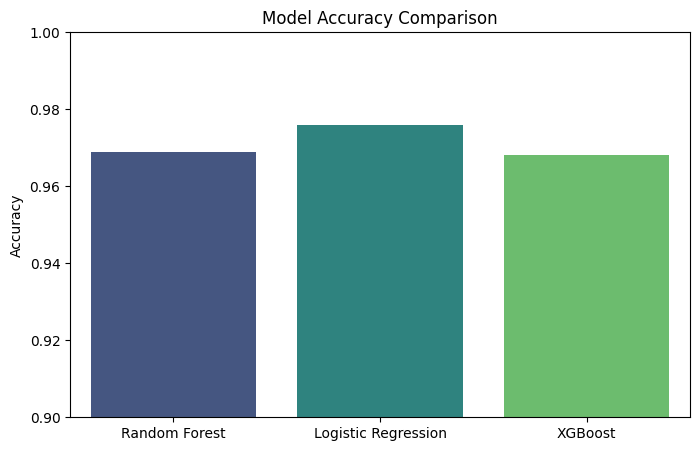

In [66]:
# Model Comparison Chart
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_xgb)
]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1)
plt.show()

C:\Users\kotha\AppData\Local\Temp\ipykernel_24696\511909819.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='coolwarm')


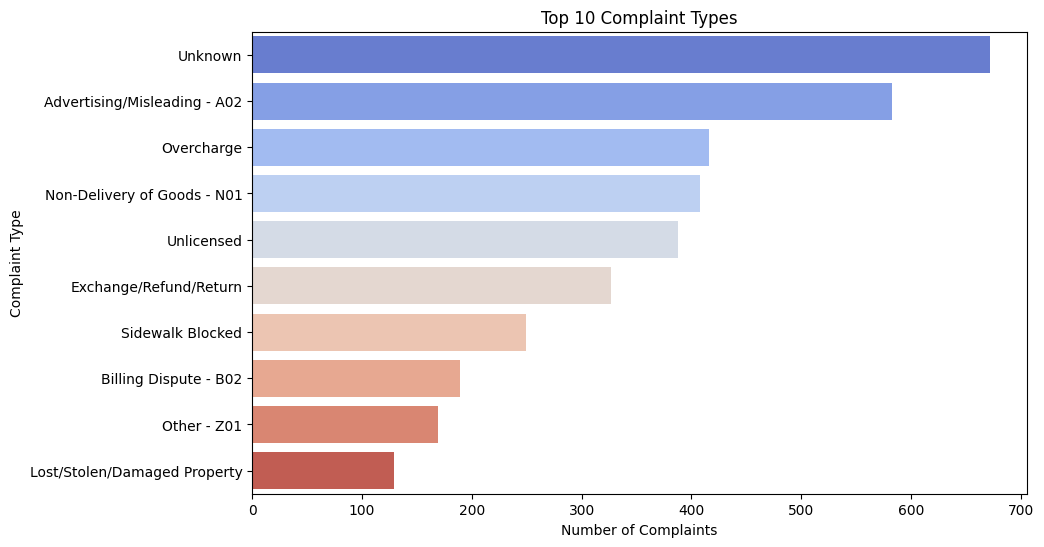

In [67]:
# Top Complaint Types
top_complaints = df['complaint_code'].value_counts().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='coolwarm')
plt.title('Top 10 Complaint Types')
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.show()

C:\Users\kotha\AppData\Local\Temp\ipykernel_24696\4034588117.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='coolwarm')


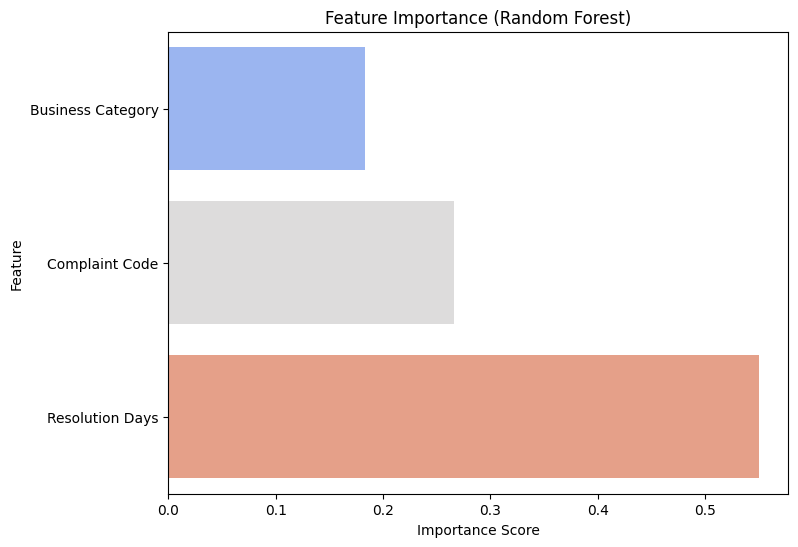

In [68]:
# Feature importance from the Random Forest model
importances = rf_model.feature_importances_
feature_names = ['Business Category', 'Complaint Code', 'Resolution Days']

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, palette='coolwarm')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

C:\Users\kotha\AppData\Local\Temp\ipykernel_24696\658660248.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='vendor_responded', order=df['vendor_responded'].value_counts().index, palette='viridis')


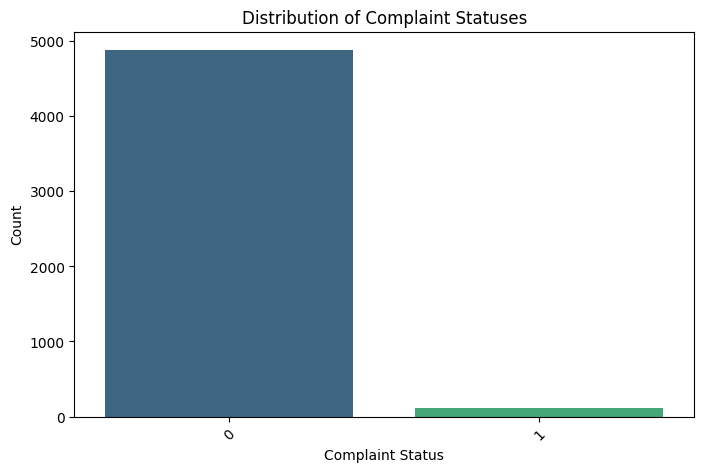

In [61]:
# Plot complaint status counts
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='vendor_responded', order=df['vendor_responded'].value_counts().index, palette='viridis')
plt.title('Distribution of Complaint Statuses')
plt.xlabel('Complaint Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The graph shows the distribution of vendor responses to consumer complaints in New York City. Specifically, it illustrates the frequency of the binary target variable vendor_responded, where 0 indicates that the vendor did not respond positively to a complaint, and 1 indicates that the vendor provided a positive resolution, such as a refund, store credit, or taking corrective action. The visualization reveals a major imbalance in the dataset: the overwhelming majority of complaints fall into the 0 category, meaning that most vendors did not provide a satisfactory response. Only a very small portion of complaints resulted in a positive outcome.

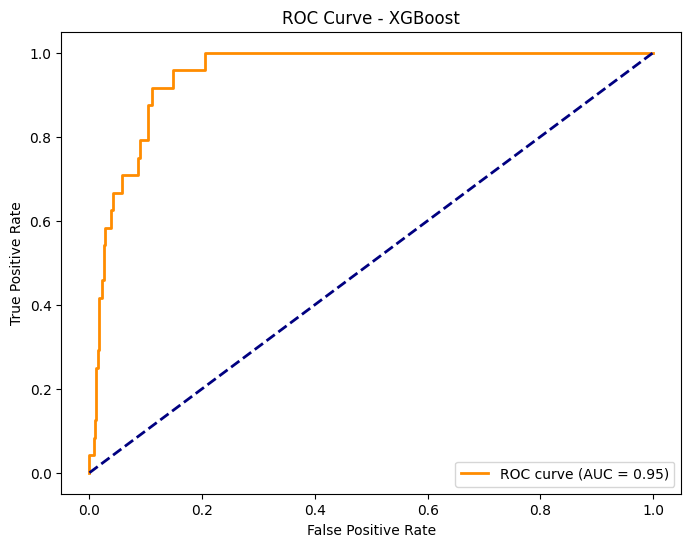

In [65]:
# Get probabilities for the positive class (1)
y_prob = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()